# Tracking wealth over time based on race and education
## Thao Nguyen, Adam Dion, Vicente Amado

### Problem Statement

In this project we are trying to explore the following problems:

1. Look at how race and education impacted net worth over time
2. Create a neural network to predict net worth based on race and education
3. Compare a neural network model to a simple handmade model -- this one may change based on what we decide to do

### Data Exploration

In [52]:
## this will stop warning boxes from showing up
import warnings
warnings.filterwarnings('ignore')

In [53]:
## Import useful libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
#Reading in the data from the federal reserve
education = pd.read_csv("dfa-education-levels.csv")
race = pd.read_csv("dfa-race-levels.csv")
networth = pd.read_csv("dfa-networth-levels.csv")
generation = pd.read_csv("dfa-generation-levels.csv")
income = pd.read_csv("dfa-income-levels.csv")


In [55]:
## cleaning all of the data
data = [education,race,networth,generation,income]
for i in range(len(data)):
    data[i] = data[i].drop(columns = data[i].columns[3:14])
    data[i][['Year','Quarter']] = pd.DataFrame(data[i].Date.str.split(':',1).tolist(), columns = ['year','quarter'])
    data[i] = data[i].drop(columns = ['Date'])
education = data[0]
race = data[1]
networth = data[2]
generation = data[3]
income = data[4]

In [56]:
## Looking at only education and race
education.head()

,Category,Net worth,Year,Quarter
0,College,10069957,1989,Q3
1,SomeCollege,3927113,1989,Q3
2,HS,4182626,1989,Q3
3,NoHS,2251459,1989,Q3
4,College,10432985,1989,Q4


In [57]:
race.head()

,Category,Net worth,Year,Quarter
0,White,18507570,1989,Q3
1,Black,779379,1989,Q3
2,Hispanic,419183,1989,Q3
3,Other,725023,1989,Q3
4,White,18751641,1989,Q4


Text(0.5, 1.0, 'Net worth over time based on education level')

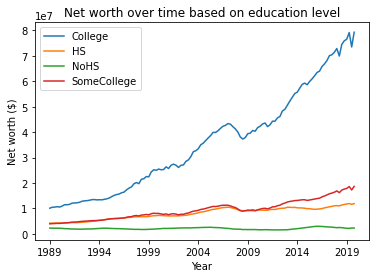

In [58]:
## plotting education to see the relationships between each category
fig, ax = plt.subplots();
education.groupby('Category').plot(x='Year', y='Net worth', ax=ax);
plt.legend([v[0] for v in education.groupby('Category')['Category']])
plt.ylabel('Net worth ($)')
plt.title('Net worth over time based on education level')

Text(0.5, 1.0, 'Net worth over time based on race')

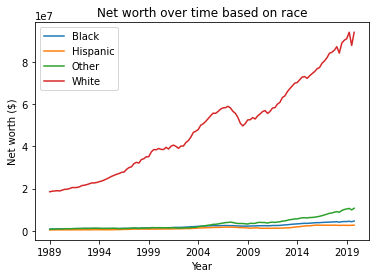

In [59]:
## plotting race to see the relationships between each category
fig, ax = plt.subplots();
race.groupby('Category').plot(x='Year', y='Net worth', ax=ax);
plt.legend([v[0] for v in race.groupby('Category')['Category']])
plt.ylabel('Net worth ($)')
plt.title('Net worth over time based on race')

Similar graphs but the gap between wealth is much larger between the races compared to educaiton level. In general, it is very hard to catch up in wealth if you had a college education or if you were born white (or both). 

### Model Development and Building

To build our model, we will take the average wealth of each group for each year and use that dataset to fit and predict. We will look at how many quarters are in a year to allow us to decide how many data points are in a given year. Every year has 4 quarters and the year resets after the last 4th quarter.

In [60]:
education.groupby('Year').apply(print)

      Category  Net worth  Year Quarter
0      College   10069957  1989      Q3
1  SomeCollege    3927113  1989      Q3
2           HS    4182626  1989      Q3
3         NoHS    2251459  1989      Q3
4      College   10432985  1989      Q4
5  SomeCollege    3992339  1989      Q4
6           HS    4177110  1989      Q4
7         NoHS    2213354  1989      Q4
       Category  Net worth  Year Quarter
8       College   10509133  1990      Q1
9   SomeCollege    4039942  1990      Q1
10           HS    4199956  1990      Q1
11         NoHS    2204833  1990      Q1
12      College   10669228  1990      Q2
13  SomeCollege    4115884  1990      Q2
14           HS    4204755  1990      Q2
15         NoHS    2193180  1990      Q2
16      College   10514904  1990      Q3
17  SomeCollege    4091622  1990      Q3
18           HS    4240137  1990      Q3
19         NoHS    2184287  1990      Q3
20      College   10915986  1990      Q4
21  SomeCollege    4174423  1990      Q4
22           HS    423517

""


In [61]:
## create list of years for each data point after looking at quarters
import numpy as np
year_init = list(np.arange(1990, 2020))*4
year_init.extend([1989, 1989, 2020, 2020])
years = np.sort(year_init)

In [62]:
## add year to dataset and split the categories to columns
s = education.groupby('Category')['Net worth'].apply(list)
edu_split = s.apply(pd.Series).T
edu_split['Year'] = years
edu_split.head()

Category,College,HS,NoHS,SomeCollege,Year
0,10069957,4182626,2251459,3927113,1989
1,10432985,4177110,2213354,3992339,1989
2,10509133,4199956,2204833,4039942,1990
3,10669228,4204755,2193180,4115884,1990
4,10514904,4240137,2184287,4091622,1990


In [63]:
## take wealth and average it by year, then drop year so it doesn't affect our distribution
edu_avg = edu_split.groupby('Year').apply(np.mean)
edu_avg = edu_avg.drop(columns='Year')
edu_avg.head()

Category,College,HS,NoHS,SomeCollege
Year,,,,
1989,10251471.00,4179868.00,2232406.50,3959726.00
1990,10652312.75,4220006.75,2177171.25,4105467.75
1991,11628279.25,4316600.75,1966321.50,4420049.50
1992,12378684.50,4461190.00,1835193.50,4746425.00
1993,13154214.50,4760919.75,1893918.00,5057583.00


In [64]:
## import necessary libraries for machine learning and additional plotting
import tensorflow as tf
from tensorflow import keras
from pandas.plotting import register_matplotlib_converters

In [65]:
# set our education dataset to df
df = edu_avg

In [66]:
## split our data into train and test (since this is a time series model, we cannot use train_test_split bc it randomizes)
train_size = int(len(df) * 0.6)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))


19 13


In [67]:
## scale the data/features by which feature we want to predict
## since we already averaged out the inital dataset, we can just use the standard scaler

from sklearn.preprocessing import StandardScaler

f_columns = ['College', 'NoHS','SomeCollege']

f_transformer = StandardScaler();
cnt_transformer = StandardScaler();

f_transformer = f_transformer.fit(train[f_columns].to_numpy());
cnt_transformer = cnt_transformer.fit(train[['HS']]);

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy());
train['HS'] = cnt_transformer.transform(train[['HS']]);

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy());
test['HS'] = cnt_transformer.transform(test[['HS']]);

In [68]:
## function to reshape our feature so it can be used in keras
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

In [69]:
## the time step that we will fit by is 1 since it is a yearly dataset
time_steps = 1

features_train = train.HS
features_test = test.HS

X_train, y_train = create_dataset(train, features_train, time_steps)
X_test, y_test = create_dataset(test, features_test, time_steps)
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')


In [70]:
## building our model
## the model is bidrectional since it is a time series model, we will take information from each time step to predict the next
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape)
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [71]:
## fitting our model
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False, 
    verbose=0
)

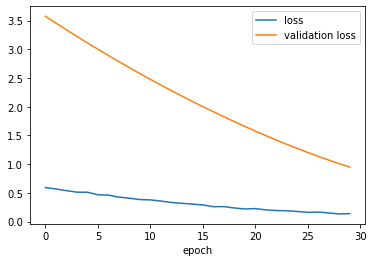

In [72]:
## looking at how well our model did
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epoch')
plt.legend();

Here, we see that loss is decreasing every epoch, which means that the accuracy of our model is increasing as it is being trained.

In [73]:
## predicting our model using the test data
y_pred = model.predict(X_test)
y_pred

array([[0.5686678 ],
       [0.36071557],
       [0.3883806 ],
       [0.42489606],
       [0.48308307],
       [0.64910823],
       [0.94610393],
       [1.2784382 ],
       [1.5847913 ],
       [1.590051  ],
       [1.4609843 ],
       [1.3358649 ]], dtype=float32)

In [74]:
## since our data is currently scaled, we have to un-scale it
y_pred = cnt_transformer.inverse_transform(y_pred)

In [75]:
## what the model predicted the wealth of high school graduates will be in years 2008-2020
y_pred

array([[7603908.5],
       [7227171. ],
       [7277290.5],
       [7343444. ],
       [7448858.5],
       [7749638.5],
       [8287691.5],
       [8889766. ],
       [9444772. ],
       [9454300. ],
       [9220476. ],
       [8993803. ]], dtype=float32)

In [76]:
## average accuracy of the model predicting this feature
acc = (cnt_transformer.inverse_transform(test.HS)[1:]/y_pred.reshape(-1))**-1
print('Accuracy:', np.mean(acc)*100)

Accuracy: 81.01863924845595


Text(0, 0.5, 'Net worth')

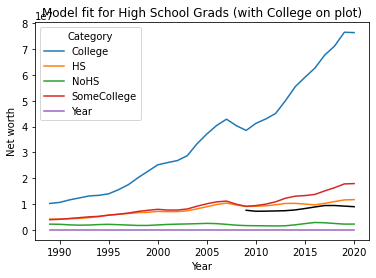

In [77]:
#graphing our prediciotn vs. the actual with all the categories on plot
edu_avg = edu_split.groupby('Year').apply(np.mean)
edu_avg.plot()
plt.plot(np.array(test.index)[1:], y_pred, label='prediction', color='black')
plt.title('Model fit for High School Grads (with College on plot)')
plt.ylabel('Net worth')

Text(0, 0.5, 'Net worth')

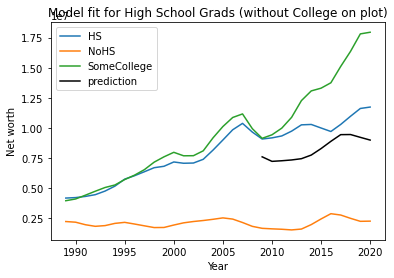

In [78]:
## plotting one without the college category to zoom in on our prediction vs. actual
edu_avg[['HS', 'NoHS', 'SomeCollege']].plot()
plt.plot(np.array(test.index)[1:], y_pred, label='prediction', color='black')
plt.legend()
plt.title('Model fit for High School Grads (without College on plot)')
plt.ylabel('Net worth')

### Presentation of Results

Now that our model works, we can write some functions so that we don't have to do these steps for every dataset/features.

In [79]:
## function to average the dataset's net worth by year and change categories to columns
def wealth_avg(df):
    # the years will be the same since our datasets are collected throughout the same time period
    year_init = list(np.arange(1990, 2020))*4
    year_init.extend([1989, 1989, 2020, 2020])
    years = np.sort(year_init)
    
    # change our categories to be columns and add year as a column
    s = df.groupby('Category')['Net worth'].apply(list)
    df_split = s.apply(pd.Series).T
    df_split['Year'] = years

    # average out the wet worth by year
    df_avg = df_split.groupby('Year').apply(np.mean)
    df_avg = df_avg.drop(columns='Year')
    return df_avg

In [80]:
## function to split our data up into training and testing sets for time series
def train_test_split(df, train_size):
    train_size = int(len(df) * train_size)
    test_size = len(df) - train_size
    train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
    print('Length of training set:', len(train))
    print('Length of testing set:', len(test))
    return train, test

In [81]:
## this will be the big function where we scale the data, build the model, fit, then predict
def neural_network(df, feature, epoch_number):
    ##scaling
    f_columns = list(df.columns[df.columns != feature])

    f_transformer = StandardScaler();
    cnt_transformer = StandardScaler();

    f_transformer = f_transformer.fit(train[f_columns].to_numpy());
    cnt_transformer = cnt_transformer.fit(train[[feature]]);

    train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy());
    train[feature] = cnt_transformer.transform(train[[feature]]);

    test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy());
    test[feature] = cnt_transformer.transform(test[[feature]]);
    
    ## reshape our feature so it can be used in keras
    time_steps = 1

    features_train = train[feature]
    features_test = test[feature]

    X_train, y_train = create_dataset(train, features_train, time_steps)
    X_test, y_test = create_dataset(test, features_test, time_steps)
    X_train = X_train.astype('float32')
    y_train = y_train.astype('float32')
    X_test = X_test.astype('float32')
    y_test = y_test.astype('float32')

    ## model
    model = keras.Sequential()
    model.add(
      keras.layers.Bidirectional(
        keras.layers.LSTM(
          units=128, 
          input_shape=(X_train.shape)
        )
      )
    )
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    ## fit
    history = model.fit(
    X_train, y_train, 
    epochs=epoch_number, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False,
    verbose=0 #we won't want to print every epoch this time
    )
    
    # loss plot to check how well our model did
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.xlabel('epochs')
    plt.legend();
    
    ## predict
    y_pred_scaled = model.predict(X_test)
    y_pred = cnt_transformer.inverse_transform(y_pred_scaled)
    
    ## average accuracy of our model
    acc = (cnt_transformer.inverse_transform(test[feature])[1:]/y_pred.reshape(-1))**-1
    print('Accuracy:', np.mean(acc)*100)

    return y_pred

Length of training set: 19
Length of testing set: 13
Accuracy: 74.91759244912764


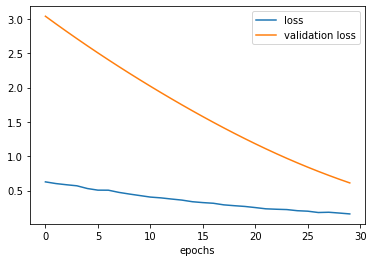

In [82]:
## using our functions to predict wealth
race_avg = wealth_avg(race)
train, test = train_test_split(race_avg, train_size = 0.6)
y_pred = neural_network(df=race_avg, feature='White', epoch_number=30)

Text(0, 0.5, 'Net worth')

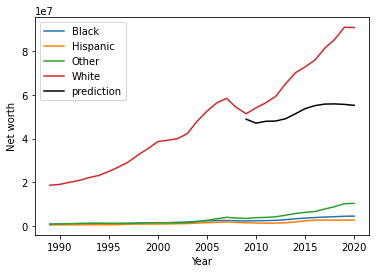

In [83]:
## we will have to call the wealth_avg function again since our race_avg got written over
race_avg = wealth_avg(race)
race_avg.plot()
plt.plot(np.array(test.index)[1:], y_pred, label='prediction', color='black')
plt.legend()
plt.ylabel('Net worth')

Here, we see that our prediction wasn't the best. This is due to the fact that we split our data in such a way that our model is predicting **after** 2008, which is when the economic recession was. This year not only caused the trend in wealth to abruptly decrease, but also created an exponential growth in wealth of people in the following years of people who weren't affected much by the recession (in this case, White people). Because our model is a time series model, it's unable to predict the growth in wealth because the last time step trend in the training dataset was a decreasing one. As a result, the time series model predicted the wealth based on the decreasing trend, making it not as accurate.

**Sources**: 
1. https://www.federalreserve.gov/releases/z1/dataviz/dfa/distribute/table/
1. https://towardsdatascience.com/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python-1d1076fc89a0
1. https://colab.research.google.com/drive/1k3PLdczAJOIrIprfhjZ-IRXzNhFJ_OTN#scrollTo=Tz9KofSH-51- 